# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Bayesian Network Deep Dive


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This code contains some in-line quality checking during the processing, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

### Initialize variables

Based on the project directory, and the site and year you have input, setvars.py will set a bunch of variables as the names of folders, files, and fields. Set-up the project folder and paths: 

In [2]:
from core.setvars import *

orig_trans = os.path.join(home, 'origTrans')
extendedTrans = os.path.join(home, 'extTrans')
extTrans_tidy = os.path.join(home, 'extTrans')

inletLines = os.path.join(home, 'BP_inletLines_2014')
ShorelinePts = os.path.join(home, 'BreezyPt2014_shoreline')
dlPts = os.path.join(home, 'BP2014_DLpts')
dhPts = os.path.join(home, 'BP2014_DHpts')

armorLines = os.path.join(home, 'BP_armorshoreward_2014')
barrierBoundary = os.path.join(home, 'bndpoly_2sl')  
shoreline = os.path.join(home, 'ShoreBetweenInlets')

elevGrid = os.path.join(home, 'BP_DEM_2014')
elevGrid_5m = os.path.join(home, 'BP_DEM_2014_5m')
slopeGrid = 'slope_5m'          # Slope in 5 m grids

SubType = os.path.join(home, 'BP14_SubType')
VegType = os.path.join(home, 'BP14_VegType')
VegDens = os.path.join(home, 'BP14_VegDen')
GeoSet = os.path.join(home, 'BP14_GeoSet')
DisMOSH = os.path.join(home, 'BP14_DisMOSH')

tr_w_anthro = os.path.join(home, 'extTrans_wAnthro')
SA_bounds = os.path.join(home, 'SA_bounds')

site: Rockaway
year: 2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014): \\Mac\stor\Projects\TransectExtraction\Rockaway2014
setvars.py initialized variables.


## Transect-averaged values
We work with the shapefile/feature class as a Pandas Dataframe as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 

In [4]:
# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']

# Get anthro fields and join to DF
trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
trans_df = fun.join_columns(trans_df, trdf_anthro) 

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

Converting feature class to array...
Converting array to dataframe...
Converting feature class to array...
Converting array to dataframe...

Header of transects dataframe (rows 1-5 out of 376): 


,AZIMUTH,LRR,TRANSECTID,TRANSORDER,sort_ID,DD_ID,Construction,Development,Nourishment
sort_ID,,,,,,,,,
1,NaN,NaN,NaN,NaN,1,20001,333.0,111.0,222.0
2,NaN,NaN,NaN,NaN,2,20002,333.0,111.0,222.0
3,NaN,NaN,NaN,NaN,3,20003,333.0,111.0,222.0
4,NaN,NaN,NaN,NaN,4,20004,333.0,111.0,222.0
5,NaN,NaN,NaN,NaN,5,20005,333.0,111.0,222.0


### Add XY and Z/slope from DH, DL, SL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point (must be within 25 m) and copy the slope value from the point to the transect in the field __Bslope__.

In [5]:
if not arcpy.Exists(shoreline):
    shoreline = fwa.CreateShoreBetweenInlets(barrierBoundary, inletLines, shoreline, ShorelinePts, proj_code, SA_bounds)

# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save as pickle
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))


Matching shoreline points to transects...
...duration at transect 100: 0:0:31.7 seconds
...duration at transect 200: 0:1:1.1 seconds
...duration at transect 300: 0:1:30.5 seconds
Duration: 0:1:52.6 seconds


In [6]:
sl2trans_df.sample(10)

,SL_x,SL_y,Bslope
sort_ID,,,
256,601307.132910,4.493382e+06,-0.081484
248,600911.674332,4.493293e+06,-0.072700
30,590817.445416,4.489083e+06,-0.015427
337,604995.315742,4.494076e+06,-0.053999
366,NaN,NaN,NaN
132,595551.880702,4.491076e+06,-0.047458
27,590690.253385,4.489002e+06,-0.019818
124,595186.371151,4.490913e+06,-0.051923
221,599619.177130,4.492889e+06,-0.058895


#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune crest point within 25 meters. 

__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__ are the eastings and northings of the points 'snapped' to the transect. "Snapping" finds the position along the transect nearest to the point, i.e. orthogonal to the transect. These values are used to find the beach width.

These values are populated as follows: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. 
2. Get the X, Y, and Z values of the point and the XY position 'snapped' to the transect. The 'snapped' XY position is calculated using the arcpy geometry method. If there are no points within 25 m of the transect, populate the row with Null values; 
3. Convert the elevations to the MHW datum by applying the MHW offset.

In [7]:
# Create dataframe for both dune crest and dune toe positions
dune2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, dlPts, trans_df, 
                                          tID_fld, proximity=pt2trans_disttolerance)

# Save
dune2trans_df.to_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))


Matching dune points with transects:
Getting name of DH Z field...
Getting name of DL Z field...
Looping through transects and dune points to find nearest point within 25 m...
...duration at transect 100: 0:0:40.6 seconds
...duration at transect 200: 0:1:18.2 seconds
...duration at transect 300: 0:1:58.0 seconds
Duration: 0:2:27.2 seconds


In [8]:
dune2trans_df.sample(10)

,DH_x,DH_y,DH_z,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY
sort_ID,,,,,,,,,,
65,592288.812205,4.490032e+06,NaN,592309.020966,4.490042e+06,NaN,NaN,NaN,NaN,NaN
89,593528.481953,4.490317e+06,4.087646,593532.763227,4.490318e+06,593533.980788,4.490304e+06,2.802947,593537.420253,4.490305e+06
100,594047.582123,4.490502e+06,3.685536,594049.245803,4.490503e+06,594054.080749,4.490487e+06,2.547460,594054.838156,4.490488e+06
172,597360.331972,4.491937e+06,NaN,597361.217865,4.491937e+06,597364.831029,4.491926e+06,NaN,597365.417356,4.491927e+06
97,593904.100655,4.490456e+06,3.387949,593907.802231,4.490457e+06,593893.016031,4.490431e+06,2.860927,593914.381107,4.490439e+06
331,604693.806908,4.494189e+06,NaN,604690.636377,4.494188e+06,604672.647407,4.494180e+06,NaN,604690.953593,4.494180e+06
152,596469.775131,4.491477e+06,NaN,596468.547499,4.491477e+06,596474.274190,4.491467e+06,NaN,596472.746988,4.491466e+06
46,591431.085639,4.489622e+06,3.960116,591435.365779,4.489625e+06,591442.750637,4.489621e+06,2.072918,591438.652613,4.489618e+06
116,594782.990241,4.490842e+06,3.889842,594783.537842,4.490842e+06,NaN,NaN,NaN,NaN,NaN


#### Armoring
__Arm_x__, __Arm_y__, and __Arm_zMHW__ are the easting, northing, and height above MHW, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 
4. Convert the elevations to the MHW datum by applying the MHW offset.

In [9]:
# Armoring line
arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid_5m)

# Save
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

Converting feature class to array with X and Y...
Converting array to dataframe...
Looks like these transects [375] are intersected by armoring lines multiple times. We will select the more seaward of the points.


### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [10]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
sl2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))
dune2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))
arm2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

In [11]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dune2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

# Display
trans_df.sample(10)

,AZIMUTH,LRR,TRANSECTID,TRANSORDER,DD_ID,Construction,Development,Nourishment,SL_x,SL_y,...,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY,Arm_x,Arm_y,Arm_z
sort_ID,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,20008,333.0,111.0,222.0,589850.534583,4.488558e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,20007,333.0,111.0,222.0,589805.557981,4.488536e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,338.07,-0.36,34.0,34.0,20134,444.0,444.0,222.0,595640.426855,4.491124e+06,...,595628.482909,4.491154e+06,NaN,NaN,NaN,NaN,NaN,595628.359577,4.491154e+06,2.933080
298,348.90,0.46,194.0,194.0,20298,444.0,444.0,222.0,603163.669539,4.493881e+06,...,603130.887891,4.494048e+06,603149.053330,4.494043e+06,3.718893,603132.446858,4.494040e+06,603133.482963,4.494035e+06,3.360280
268,338.07,1.59,168.0,168.0,20268,444.0,444.0,222.0,601891.662569,4.493537e+06,...,601857.104215,4.493622e+06,601852.838734,4.493611e+06,2.835860,601860.331877,4.493614e+06,601858.258654,4.493620e+06,3.412125
297,348.90,0.56,193.0,193.0,20297,444.0,444.0,222.0,603113.976826,4.493874e+06,...,603083.578645,4.494029e+06,603082.517799,4.494020e+06,3.487416,603085.262449,4.494021e+06,603085.866697,4.494018e+06,3.268360
39,NaN,NaN,NaN,NaN,20039,111.0,444.0,222.0,591215.197011,4.489293e+06,...,591125.714611,4.489462e+06,591132.955329,4.489456e+06,2.147935,591129.809547,4.489454e+06,NaN,NaN,NaN
373,NaN,NaN,NaN,NaN,20373,444.0,444.0,222.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606703.626341,4.494520e+06,0.555400
69,NaN,NaN,NaN,NaN,20069,111.0,444.0,222.0,592562.412473,4.490001e+06,...,592530.055225,4.490075e+06,592543.319544,4.490049e+06,1.721854,592541.679695,4.490048e+06,NaN,NaN,NaN


### Check for errors: display summary stats / histograms and create feature classes
*Optional*

The feature classes will display the locations that will be used to calculate beach width. Output files for validation:

- pts2trans_SL
- ptSnap2trans_DL
- ptSnap2trans_DH
- arm2trans

          AZIMUTH         LRR  TRANSECTID  TRANSORDER         DD_ID  \
count  197.000000  197.000000  197.000000  197.000000    376.000000   
mean   339.940457    0.633401  108.604061  108.604061  20188.500000   
std      4.852957    0.602143   58.625111   58.625111    108.686092   
min    338.070000   -0.490000    3.000000    3.000000  20001.000000   
50%    338.070000    0.610000  108.000000  108.000000  20188.500000   
max    355.040000    2.190000  211.000000  211.000000  20376.000000   

       Construction  Development  Nourishment           SL_x          SL_y  \
count    376.000000   376.000000        376.0     344.000000  3.440000e+02   
mean     386.433511   395.880319        222.0  597631.436474  4.491836e+06   
std      122.920618    96.655065          0.0    4590.687315  1.740392e+03   
min      111.000000   111.000000        222.0  589758.151996  4.488519e+06   
50%      444.000000   444.000000        222.0  597625.860710  4.492016e+06   
max      444.000000   444.000000  

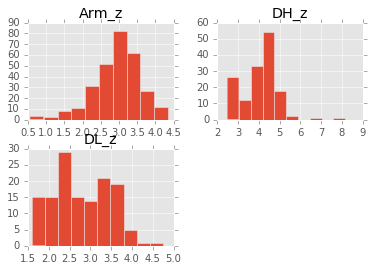

In [12]:
print(trans_df.describe([]))

trans_df.hist(['DH_z', 'DL_z', 'Arm_z'])
plt.show()
plt.close()

In [13]:
# Convert dataframe to feature class - shoreline points with slope
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.scratchGDB, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])

# Dune crests
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DH'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])
except Exception as err:
    print(err)
    pass

# Dune toes
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DL'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])
except Exception as err:
    print(err)
    pass

### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_x__, __DL_y__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
1. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_x__, __DL_y__ and __DH_x__, __DH_y__)
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zMHW__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zMHW__) to __uBW__ and __uBH__, respectively. 

In [14]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

In [15]:
#%% Calculate distances from shore to dunes, etc.
trans_df  = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, sitevals['MHW'], fill, skip_missing_z=True)

### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) is computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline instead of simply a Euclidean distance and reflects sediment transport pathways. It is measured using the oceanside shoreline between inlets (ShoreBetweenInlets). 

Note that the ShoreBetweenInlets feature class must be both 'dissolved' and 'singlepart' so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. 

The process uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module. The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [18]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Save
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

Duration: 0:0:4.6 seconds


In [19]:
dist_df.tail(10)

,Dist2Inlet
sort_ID,
340.0,438.791766
341.0,389.523890
342.0,340.789207
343.0,292.124316
344.0,243.225999
345.0,194.447230
346.0,145.841662
347.0,97.160504
348.0,48.658929


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

Temporary layers (assuming default names):

- clip2island
- clip2islandSingle_temp'

In [20]:
# Clip transects, get barrier widths *SPATIAL*
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# # Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))
# widths_df = pd.read_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

Getting the width along each transect of the oceanside land (WidthPart)...
Converting feature class to array...
Converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
Converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


In [21]:
trans_df.sample(10)

,AZIMUTH,LRR,TRANSECTID,TRANSORDER,DD_ID,Construction,Development,Nourishment,SL_x,SL_y,...,DistDL,DistDH,DistArm,uBW,uBH,ub_feat,Dist2Inlet,WidthFull,WidthLand,WidthPart
sort_ID,,,,,,,,,,,,,,,,,,,,,
347,NaN,NaN,NaN,NaN,20347,444.0,444.0,222.0,605486.267916,4.494073e+06,...,NaN,64.681040,180.586312,180.586312,1.900800,Arm,97.160504,2151.578415,2151.578415,2151.578415
218,338.07,0.36,118.0,118.0,20218,444.0,444.0,222.0,599481.505522,4.492829e+06,...,26.617535,47.858897,55.648204,55.648204,3.411960,Arm,6338.708114,715.162015,715.162015,715.162015
328,NaN,NaN,NaN,NaN,20328,444.0,444.0,222.0,604543.452129,4.494114e+06,...,41.088332,49.686433,44.916046,41.088332,2.964038,DL,1046.329747,2503.360358,2503.360358,2503.360358
61,NaN,NaN,NaN,NaN,20061,111.0,444.0,222.0,592191.370561,4.489802e+06,...,208.925157,220.144163,NaN,NaN,NaN,NaN,2807.091084,1149.296577,1149.296577,1149.296577
117,338.07,-0.11,17.0,17.0,20117,444.0,333.0,222.0,594873.174669,4.490754e+06,...,66.886784,72.280705,68.722524,68.722524,2.515520,Arm,5722.776909,750.956909,750.956909,750.956909
374,NaN,NaN,NaN,NaN,20374,444.0,444.0,222.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1583.901876,1583.901876,1583.901876
46,NaN,NaN,NaN,NaN,20046,111.0,444.0,222.0,591528.066684,4.489450e+06,...,190.492673,197.495126,NaN,190.492673,1.612918,DL,2055.097726,1352.294576,1352.294576,1352.294576
288,NaN,NaN,NaN,NaN,20288,444.0,444.0,222.0,602702.538116,4.493758e+06,...,125.374763,136.686757,141.801773,125.374763,3.616798,DL,2935.616322,1506.168205,1278.485237,1103.254362
110,NaN,NaN,NaN,NaN,20110,444.0,333.0,222.0,594550.258595,4.490619e+06,...,77.912056,84.159578,54.884204,77.912056,2.801305,DL,5368.702464,904.306147,904.306147,904.306147


## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

It is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed witha Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

Temporary files: 
- tran5mPts_unsorted

In [22]:
# if os.path.exists(os.path.join(scratch_dir, pts_name+'_null.pkl')):
#     pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))
#     trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
extTrans_tidy = os.path.join(home, 'extTrans')
pts_df, pts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=os.path.join(arcpy.env.scratchGDB, 'transPts_unsorted')) # 5 minutes for FireIsland

Getting points every 5m along each transect and saving in both dataframe and feature class...
Converting new dataframe to feature class...
Duration: 0:4:24.3 seconds


### Add Elevation and Slope to points

__ptZmhw__ and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe

In [23]:
# Create elevation and slope rasters at 5-m resolution
if not arcpy.Exists(elevGrid_5m):
    fwa.ProcessDEM(elevGrid, elevGrid_5m, utmSR)
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid_5m, slopeGrid, 'PERCENT_RISE')
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, 
                                    [[elevGrid_5m, 'ptZ'], [slopeGrid, 'ptSlp']])

<geoprocessing server result object at 0xc143e18>

In [24]:
# Add substrate type, geomorphic setting, veg type, veg density values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                       [VegDens, 'VegDens'], [GeoSet, 'GeoSet'],
                                                        [DisMOSH, 'DisMOSH']])

# Convert to dataframe
pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                         'VegType', 'VegDens', 'GeoSet','DisMOSH'])
# Recode fill values
pts_df.replace({'GeoSet': {9999:np.nan}, 'SubType': {9999:np.nan}, 'VegType': {9999:np.nan},
                'VegDens': {9999:np.nan}, 'DisMOSH': {9999:np.nan}}, inplace=True)

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))

# View 10 randomly selected rows 
pts_df.sample(10)

Converting feature class to array with X and Y...
Converting array to dataframe...


,DisMOSH,GeoSet,SHAPE@X,SHAPE@Y,SubType,VegDens,VegType,ptSlp,ptZ,sort_ID
46552,99999.000000,5.0,599783.593083,4.493016e+06,6666.0,555.0,55.0,4.574699,3.50972,225.0
44823,99999.000000,5.0,598950.523809,4.492943e+06,6666.0,555.0,55.0,3.752956,2.87548,209.0
17914,99999.000000,5.0,605362.284632,4.495146e+06,6666.0,555.0,55.0,2.614428,8.06100,347.0
30762,99999.000000,5.0,604565.593034,4.494820e+06,6666.0,555.0,55.0,1.149720,2.18228,329.0
59631,0.000000,2.0,593423.752800,4.491062e+06,7777.0,666.0,77.0,9.123375,1.02148,92.0
37154,99999.000000,5.0,600914.012986,4.493689e+06,6666.0,555.0,55.0,5.436411,1.84276,251.0
44361,99999.000000,5.0,598457.011671,4.492964e+06,6666.0,555.0,55.0,0.570323,2.17472,200.0
64750,99999.000000,5.0,596092.300951,4.491474e+06,6666.0,555.0,55.0,NaN,NaN,145.0
71863,99999.000000,5.0,593930.867077,4.490968e+06,NaN,888.0,99.0,0.484034,1.61020,101.0
73123,6430.229492,2.0,594848.901207,4.490814e+06,1111.0,111.0,11.0,4.221422,2.56800,117.0


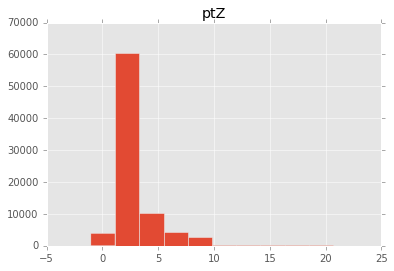

In [25]:
pts_df.hist('ptZ')
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [27]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# Save dataframes to open elsewhere or later
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View 10 randomly selected rows 
pts_df.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
77804,77804,605643.297848,4.495031e+06,NaN,NaN,NaN,NaN,NaN,7.143000,NaN,...,1988.166401,2015.733402,NaN,NaN,NaN,4.618480,8.78464,444.0,444.0,222.0
84856,84856,606364.665733,4.496034e+06,NaN,NaN,NaN,NaN,NaN,7.619600,2.203938,...,1760.417337,1760.417337,NaN,NaN,NaN,3.858541,7.78948,444.0,444.0,222.0
45459,45459,601086.159799,4.494466e+06,1109.999993,64.561942,NaN,NaN,1026.868523,2.355680,2.249178,...,1174.561934,1174.561934,83.131469,2.462200,Arm,1.835137,3.85188,444.0,444.0,222.0
13219,13219,591861.004019,4.490826e+06,1060.000028,102.475855,892.569807,901.313923,NaN,2.239083,3.600968,...,1162.475882,1162.475882,NaN,NaN,NaN,1.533551,3.37212,111.0,444.0,222.0
18583,18583,593873.435098,4.490405e+06,34.999966,946.973691,-29.165960,-17.916549,4.993133,2.394680,1.409903,...,981.973657,981.973657,52.843888,2.291268,DL,1.739650,5.34264,444.0,333.0,222.0


### Recode the values for CSV output and model running

In [42]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save as pickle
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))

# Take a look at some rows
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
54304,54304,602618.306724,4.495362e+06,1572.256223,-298.015404,1403.700501,1414.949356,1415.621819,0.99952,0.753777,...,1365.255703,1632.511894,157.285199,3.185983,DL,2.047117,5.334120,444.0,444.0,222.0
28003,28003,596213.956011,4.492243e+06,855.000014,47.185687,802.006461,813.237377,782.030878,1.53260,0.976130,...,902.185701,902.185701,72.969136,2.666120,Arm,1.682810,3.975080,444.0,444.0,222.0
53763,53763,602515.469858,4.495367e+06,1608.386212,-403.155621,1451.393519,-99999.000000,1460.936835,0.16736,6.039706,...,1404.114644,1617.500868,147.449377,3.543360,Arm,1.791635,4.696480,444.0,444.0,222.0
2654,2654,590057.371935,4.489660e+06,879.999987,390.897795,756.016849,776.953279,-99999.000000,0.80500,1.995350,...,1270.897782,1270.897782,102.969052,1.251962,DL,1.276609,5.110920,111.0,111.0,222.0
59460,59460,603480.802071,4.495536e+06,1547.400535,-397.856498,1415.554689,1426.697993,1425.992102,13.24740,4.129914,...,2005.925462,2168.325975,120.701311,2.841700,DL,5.973783,16.262482,444.0,444.0,222.0


In [29]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
84363,84363,606273.783204,4.496212e+06,NaN,NaN,NaN,NaN,NaN,6.92812,1.206586,...,1855.818681,1855.818681,NaN,NaN,NaN,4.090258,8.404059,444.0,444.0,222.0
16463,16463,593072.075460,4.490564e+06,424.999971,268.095395,334.612461,360.746251,402.428646,1.30492,2.723355,...,693.095366,693.095366,64.183818,2.267720,DL,2.095716,9.385760,444.0,222.0,222.0
54293,54293,602680.351284,4.495046e+06,1250.000032,24.240787,1081.444310,1092.693165,1093.365628,1.95780,3.430011,...,1365.255703,1632.511894,157.285199,3.185983,DL,2.047117,5.334120,444.0,444.0,222.0
53489,53489,602820.322028,4.493813e+06,24.999987,1180.230603,-131.992705,NaN,-122.449390,1.63548,2.614739,...,1404.114644,1617.500868,147.449377,3.543360,Arm,1.791635,4.696480,444.0,444.0,222.0
61657,61657,603948.458639,4.494773e+06,715.000026,91.109206,635.140045,643.854913,643.843811,2.15176,2.480619,...,1042.468133,2529.424438,71.074907,2.733522,DL,1.645897,4.277905,444.0,444.0,222.0


## Quality checking
Look at extracted profiles from around the island. Entered the transect ID within the available range when prompted. Evaluated the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality.

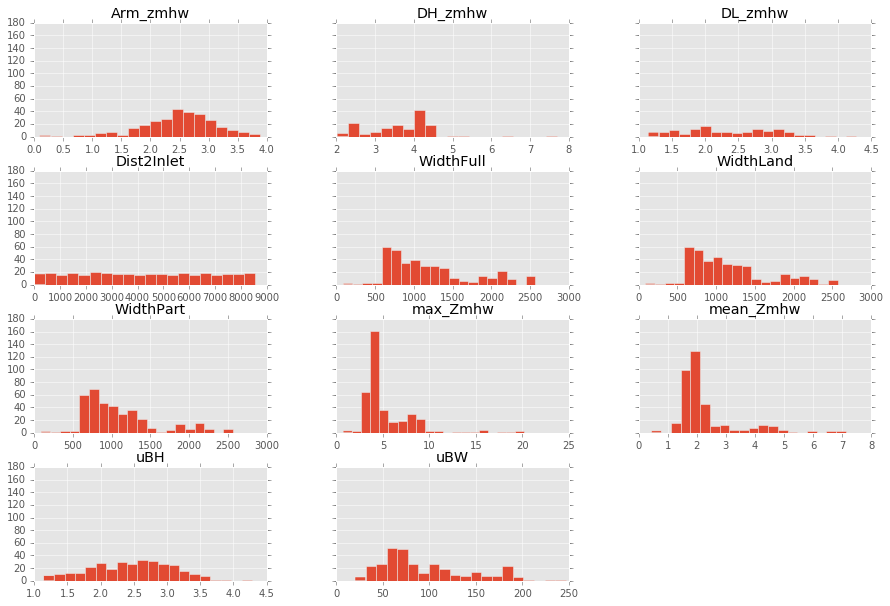

In [30]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']

# Histograms
trans_df.hist(desccols, sharey=True, figsize=[15, 10], bins=20)
plt.show()
plt.close('all')

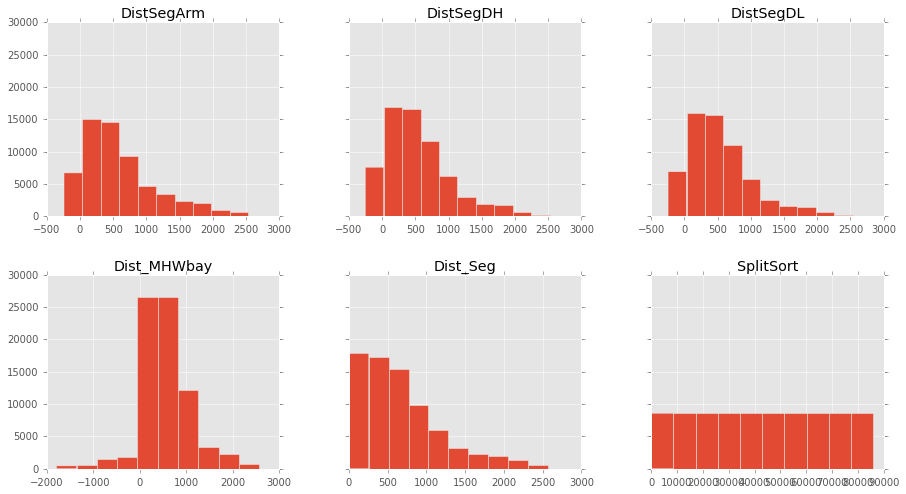

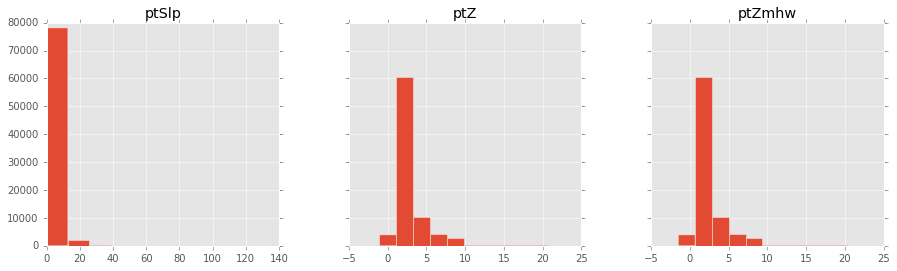

In [31]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))
plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-376): 250


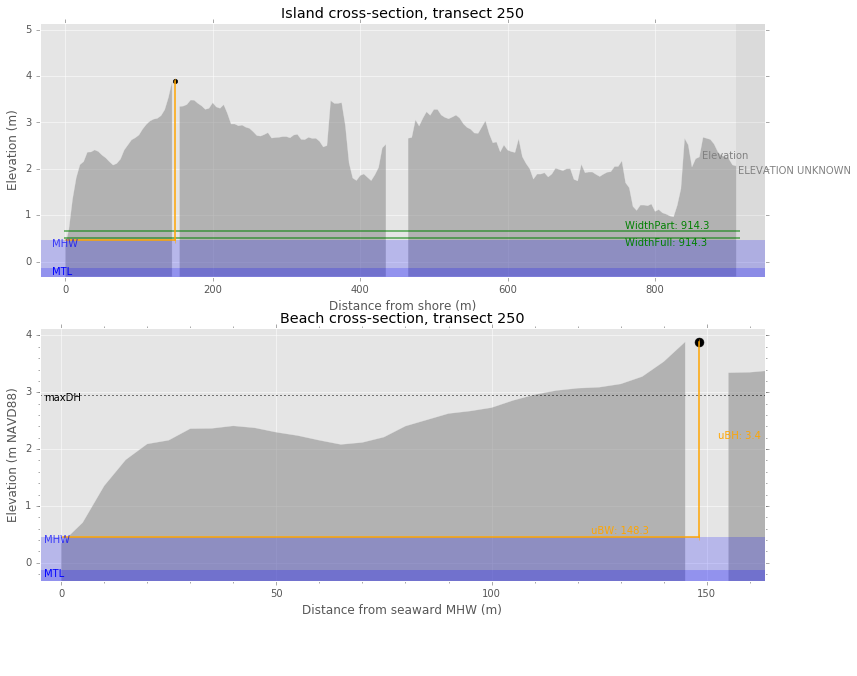

In [32]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
fun.plot_island_profile(ax1, pts_set, sitevals['MHW'], sitevals['MTL'])

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
fun.plot_beach_profile(ax2, pts_set, sitevals['MHW'], sitevals['MTL'], maxDH)

# Display
plt.show()
plt.close('all')

## Outputs

### Transect-averaged
#### Vector format

In [33]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

In [38]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created rock14_trans_fill from input dataframe and extTrans file.
OUTPUT: rock14_trans_null
OUTPUT: rock14_trans_shp.shp in specified scratch_dir.


#### Raster - beach width

In [39]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transID):
    print("{} was not found so we will create the base raster.".format(os.path.basename(rst_transID)))
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transID))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, os.path.basename(rst_transID), bw_rst, fill, tID_fld, 'uBW')

OUTPUT: rock14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points

#### Tabular format

Save final pts with fill values as CSV

In [3]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))

In [17]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(csv_fname)))

OUTPUT: rock14_pts.csv in specified scratch_dir.


#### Vector format

In [45]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP and XLS with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
OUTPUT: rock14_pts_fill
Duration: 0:6:58.6 seconds
OUTPUT: rock14_pts_null
OUTPUT: rock14_pts_shp.shp in specified scratch_dir.


### Report values for Entity and Attribute Information 

In [46]:
print('{}{} -- Number of points in dataset: {}'.format(site, year, pts_df4csv.shape))
for fld in pts_df4csv.columns:
    if fld in ['GeoSet', 'SubType', 'VegDens', 'VegType', 'Construction', 'Development', 'Nourishment', 'ub_feat']:
        print('{} values: {}'.format(fld, '  |  '.join(str(x) for x in pts_df4csv.loc[:,fld].unique())))
    else:
        if not any(pd.isnull(pts_df4csv.loc[:,fld])):
            mn = min(pts_df4csv.loc[:,fld])
        else:
            mn = -99999
        mx = np.max(pts_df4csv.loc[:,fld])
        print('{} min|max: {}  |  {}'.format(fld, mn, mx))

Rockaway2014 -- Number of points in dataset: (85936, 54)
SplitSort min|max: 0  |  85935
seg_x min|max: -99999.0  |  606857.4244118808
seg_y min|max: -99999.0  |  4496663.707794331
Dist_Seg min|max: -99999.0  |  2564.999972378326
Dist_MHWbay min|max: -99999.0  |  2566.1516249920132
DistSegDH min|max: -99999.0  |  2523.0856470807003
DistSegDL min|max: -99999.0  |  2531.797153888941
DistSegArm min|max: -99999.0  |  2533.2068455604176
ptZ min|max: -99999.0  |  20.68008041381836
ptSlp min|max: -99999.0  |  128.31585693359375
ptZmhw min|max: -99999.0  |  20.220081329345703
GeoSet values: -99999.0  |  1.0  |  2.0  |  5.0  |  3.0  |  4.0
SubType values: -99999  |  4444.0  |  {1111, 2222}  |  6666.0  |  2222.0  |  1111.0
VegDens values: -99999  |  111.0  |  {111, 222}  |  555.0  |  222.0  |  333.0  |  444.0  |  {333, 444}
VegType values: -99999  |  11.0  |  {11, 22}  |  55.0  |  22.0  |  33.0  |  {33, 44}  |  {22, 33}
sort_ID min|max: 1.0  |  376.0
TRANSORDER min|max: -99999.0  |  211.0
TRANSEC

In [ ]:
!jupyter nbconvert --to pdf extractor_Rockaway2014.ipynb

In [16]:
trans_flds = ['TRANSECTID', 'TRANSORDER', 'DD_ID']
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created rock_trans from input dataframe and extTrans file.
OUTPUT: rock_trans.shp in specified scratch_dir.
